Data is split, training and test data has shape:
(2000, 240, 1) (2000,) (2000, 240, 1) (2000,)
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4961 - mean_squared_error: 0.4961 - val_loss: 0.5740 - val_mean_squared_error: 0.5740
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - loss: 0.4548 - mean_squared_error: 0.4548 - val_loss: 0.5326 - val_mean_squared_error: 0.5326
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - loss: 0.4074 - mean_squared_error: 0.4074 - val_loss: 0.5070 - val_mean_squared_error: 0.5070
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step - loss: 0.3884 - mean_squared_error: 0.3884 - val_loss: 0.4879 - val_mean_squared_error: 0.4879
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3534 - mean_squared_error: 0.3534 - val_loss: 0.4720 - val_mean_squared_error: 0.4720
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - loss: 0.3337 - mean_squared_error: 0.3337 - val_loss: 0.4554 - val_mean_squared_error: 0.4554
Epoch 7/1000
1/1 ━━━━━━

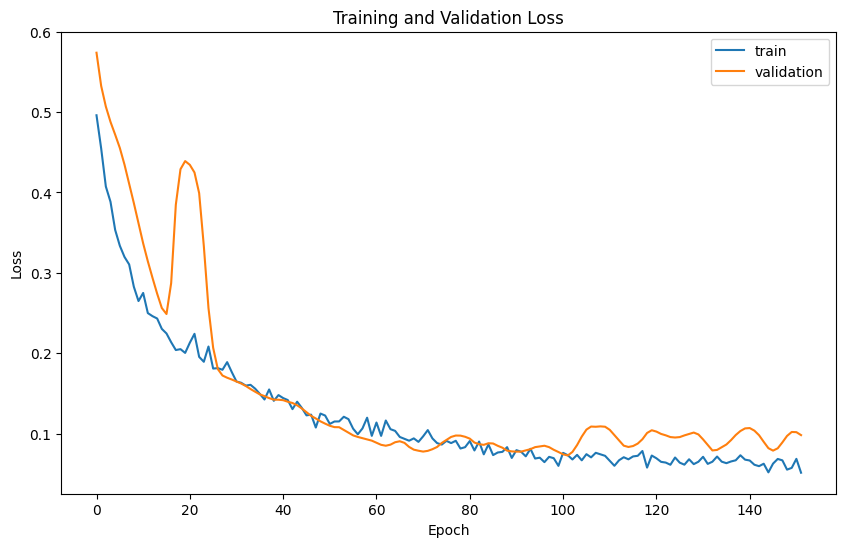

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, InputLayer, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM
import tensorflow as tf

import preprocess, fit_nn

architecture = "LSTM_LoCap"

TL = True

source_contract = "GMMB"
source_lapse = "lapse"
source_noiseLevel = "LowNoise"
source_dataSize = 50000

target_contract = "GMMB"
target_lapse = "dlapse"
target_noiseLevel = "LowNoise"
target_dataSize = 2000
test_size = 0
seed = 22
n_epochs = 1000
batch_size = 4096
patience = 50
lr = 0.0001
dropout = 0.1 
decay_rate = 0.9
layer_freeze = 1
freeze_lstm = False

if TL:
    source_model_path = f"./trainedModels/{source_contract}_PY/{source_lapse}/{architecture}_{source_noiseLevel}_{source_dataSize}/trained_model.keras"

    source_model = tf.keras.models.load_model(source_model_path)

    if layer_freeze > 0:
        if freeze_lstm:
            for layer in source_model.layers[:layer_freeze]:
                layer.trainable = False
        else:
            source_model.layers[2].trainable = False

        target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}_layerFreezing/"
    else:
        target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}_fineTuning/"

else:

    target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}/"
    cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

    price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")
    rtn = (price[:, 1:] - price[:, :-1]) / price[:, :-1]

    if target_noiseLevel == "LowNoise":
        N = 100
    else:
        N = 10

    substring = f"hedgingLoss_{target_contract}_RS_{N}_{target_lapse}"
    loss_file = [file for file in os.listdir(cwd) if substring in file and os.path.isfile(os.path.join(cwd, file))][0]


    X_train, y_train, X_test, y_test, y_mean, y_std = preprocess.transform_data(rtn, np.load(cwd + loss_file), True, test_size, seed,
                                                                                part=True, part_size=target_dataSize)
    
    model_name = "LSTM"
    recurrent_layer_size = [32, 4]
    dense_layer_size = 32
    activation_function = "tanh"

    source_model = fit_nn.build_model(X_train, 
                                      model_name, recurrent_layer_size, dense_layer_size, 
                                      activation_function, lr, dropout, decay_rate)


if not os.path.exists(target_model_path):
    os.makedirs(target_model_path)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                                 decay_steps=1000,
                                                                 decay_rate=decay_rate)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

source_model.compile(loss="mean_squared_error",
                     optimizer=optimizer, metrics=['mean_squared_error'])

cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")
rtn = (price[:, 1:] - price[:, :-1]) / price[:, :-1]

substring = f"hedgingLoss_{target_contract}_RS_100_{target_lapse}"
loss_file = [file for file in os.listdir(cwd) if substring in file and os.path.isfile(os.path.join(cwd, file))][0]

X_train, y_train, X_test, y_test, y_mean, y_std = preprocess.transform_data(rtn, np.load(cwd + loss_file), True, test_size, seed,
                                                                            part=True, part_size=target_dataSize)


target_model, running_time = fit_nn.train_model(X_train, y_train, source_model, n_epochs, batch_size, patience, target_model_path)

target_model.save(target_model_path + "trained_model.keras")

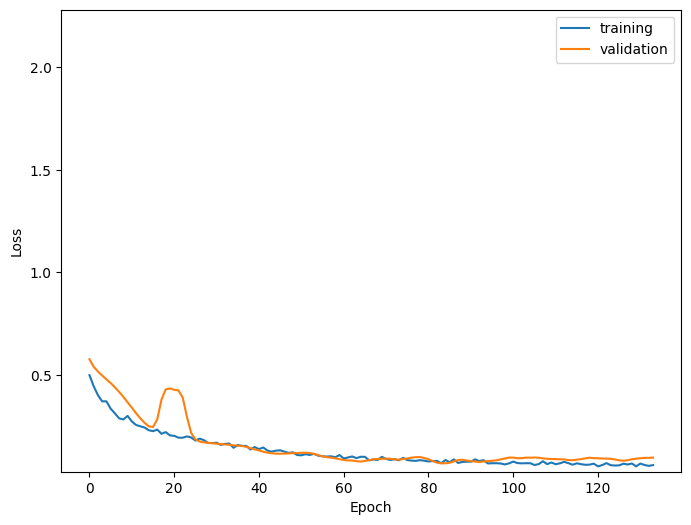

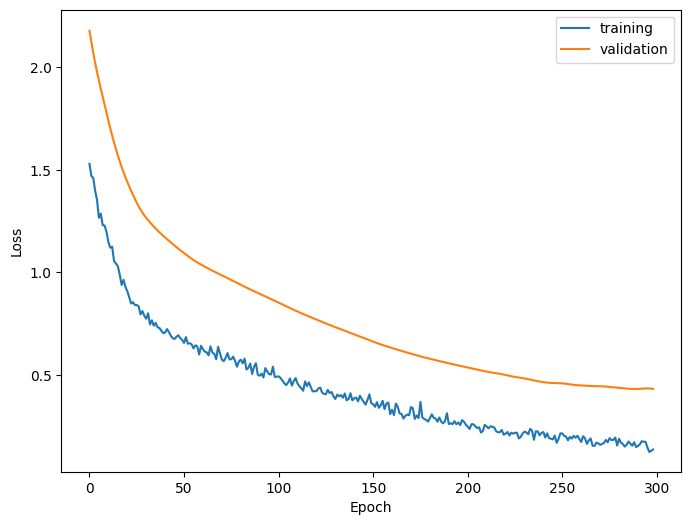

In [21]:
figure_path = "./figuresP3/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)


history = pd.read_csv("./trainedModels/GMMB_PY/dlapse/LSTM_LoCap_LowNoise_2000/training_history_00005.csv")
history_LF = pd.read_csv("./trainedModels/GMMB_PY/dlapse/LSTM_LoCap_LowNoise_2000_layerFreezingfromNolapse/training_history.csv")
history_LF_lapse = pd.read_csv("./trainedModels/GMMB_PY/dlapse/LSTM_LoCap_LowNoise_lapse_2000_fineTuning/training_history.csv")

plt.figure(figsize=(8, 6))
plt.plot(history_LF_lapse["epoch"], history_LF_lapse["loss"], label="training")
plt.plot(history_LF_lapse["epoch"], history_LF_lapse["val_loss"], label="validation")
plt.legend()
plt.ylim((0.02858142647892229, 2.2808168549090624))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("Fine Tuning")
plt.savefig(figure_path + "figure2b.png")


plt.figure(figsize=(8, 6))
plt.plot(history_LF["epoch"], history_LF["loss"], label="training")
plt.plot(history_LF["epoch"], history_LF["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0.02858142647892229, 2.2808168549090624))
# plt.title("Fine Tuning")
plt.savefig(figure_path + "figure2a.png")


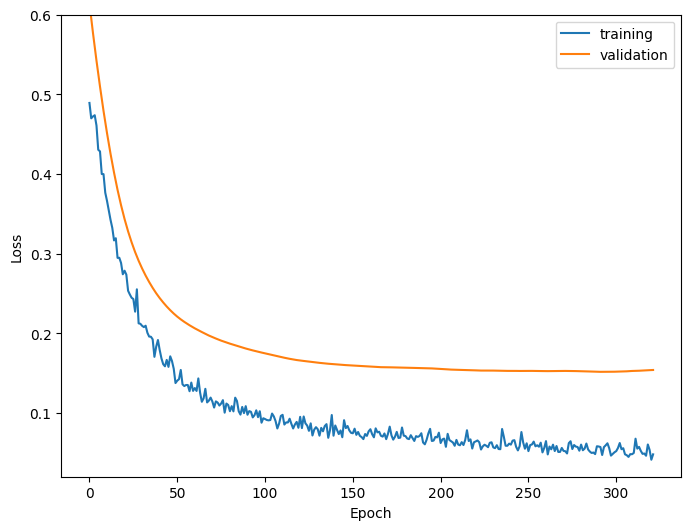

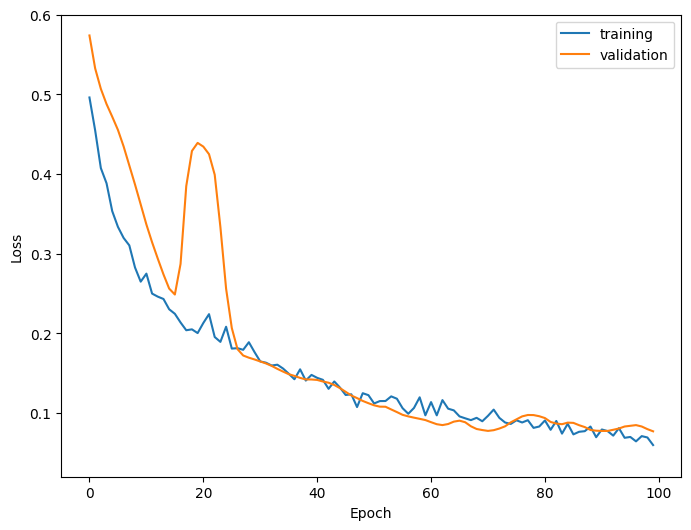

In [30]:
history_FreezeLSTM = pd.read_csv("./trainedModels/GMMB_PY/dlapse/LSTM_LoCap_LowNoise_lapse_2000_layerFreezing/training_history.csv")[:100]
history_FreezeFC = pd.read_csv("./trainedModels/GMMB_PY/dlapse/LSTM_LoCap_LowNoise_lapse_2000_layerFreezing_LSTM/training_history.csv")

plt.figure(figsize=(8, 6))
plt.plot(history_FreezeFC["epoch"], history_FreezeFC["loss"], label="training")
plt.plot(history_FreezeFC["epoch"], history_FreezeFC["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0.02, 0.6))
# plt.title("Layer Freezing")
plt.savefig(figure_path + "figure3a.png")


plt.figure(figsize=(8, 6))
plt.plot(history_FreezeLSTM["epoch"], history_FreezeLSTM["loss"], label="training")
plt.plot(history_FreezeLSTM["epoch"], history_FreezeLSTM["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0.02, 0.6))
# plt.title("Layer Freezing")
plt.savefig(figure_path + "figure3b.png")